In [1]:
# Pull data from data file
# Extract X_all and U_all from data file
# Polynomial fit with 5? coeffs in each dimension
# Store coeffs in a separate data file along with train_input


# Separate notebook:
# Create NN to read train_input, train_output (coeffs) and train on them

In [88]:
using Polynomials
using LinearAlgebra
using JLD2, FileIO
using Plots
using StatsPlots
using Statistics
include("astrobee_se3_script.jl")


plot_square (generic function with 1 method)

# Demo of polyfit functionality

In [2]:
x = range(0,stop=2*pi,length=100)
y = map(sin, x)

num_coeffs = 6
p = polyfit(x, y, num_coeffs-1, :t)

@show coeffs(p)

x2 = range(pi,stop=2*pi,length=10)
y2_true = map(sin, x2)
y2_est = polyval(p, x2)
@show y2_true
@show y2_est 
@show (y2_est - y2_true)
norm(y2_est - y2_true)./y2_true

t = range(0,stop=10,length = 100)
y = map(t->0.1, t)
p = polyfit(t,y,5,:t)

coeffs(p) = [0.0128679, 0.871069, 0.276754, -0.397869, 0.0879739, -0.00560059]
y2_true = [1.22465e-16, -0.34202, -0.642788, -0.866025, -0.984808, -0.984808, -0.866025, -0.642788, -0.34202, -2.44929e-16]
y2_est = [1.66187e-15, -0.338049, -0.637441, -0.863005, -0.986533, -0.990267, -0.870382, -0.640465, -0.335005, -0.0128679]
y2_est - y2_true = [1.5394e-15, 0.00397154, 0.00534633, 0.00302031, -0.00172535, -0.00545957, -0.00435631, 0.00232239, 0.00701546, -0.0128679]


Poly(0.10000000000000006 - 9.531213857312475e-17*t + 6.212603408933735e-17*t^2 - 1.6850713204784723e-17*t^3 + 1.9790052158011004e-18*t^4 - 8.281315220670178e-20*t^5)

# Helper functions

In [3]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

# How to recover solutions from training data

In [4]:
function getComponentsFromData(train_input, train_output)
    N = 50 
    x_dim = 13
    u_dim = 6
    x_init = train_input[1:x_dim]
    x_final = train_input[x_dim+1:end]
    X_row = train_output[1:x_dim*N]
    X_soln = reshape(X_row, (x_dim,N))
    U_row = train_output[(1+x_dim*N) : end]
    U_soln = reshape(U_row, (u_dim,N-1))
    return x_init, x_final, X_soln, U_soln
end

getComponentsFromData (generic function with 1 method)

In [5]:
function plotCoeffs(coeffs)
    gr(fmt=:png)
    plot()
    plot!(coeffs,
        xlabel = "#",
        ylabel = "coeff",
        legend = :none)
    plot!()
end

plotCoeffs (generic function with 1 method)

# Split up large file to two smaller files

In [6]:
# @load "SimpleAstrobee.jld2" train_input_collected train_output_collected
# @show size(train_input_collected)
# @show size(train_output_collected)
# train_input_collected_1 = train_input_collected[1:10000,:]
# train_output_collected_1 = train_output_collected[1:10000,:]
# train_input_collected_2 = train_input_collected[10001:end,:]
# train_output_collected_2 = train_output_collected[10001:end,:]
# @save "SimpleAstrobeeFirst10000.jld2" train_input_collected_1 train_output_collected_1
# @save "SimpleAstrobeeRest.jld2" train_input_collected_2 train_output_collected_2



# Collect coefficients for all the data

In [7]:
# Get saved data
@load "PolyMore.jld2" train_input_collected train_output_collected
@show size(train_input_collected)
@show size(train_output_collected)

N = 50
tf_guess = 110.
t_array = range(0,stop=tf_guess,length=N)
t_minus_one_array = t_array[1:end-1]
num_coeffs = 5
num_rows = size(train_input_collected,1)
x_dim = 13
u_dim = 6

all_coeffs = zeros(num_rows, num_coeffs*(x_dim+u_dim))


for row in 1:num_rows
# for row in 1:300
    train_input = train_input_collected[row, :]
    train_output = train_output_collected[row, :]
    x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
    
    # Get fitted polynomial coefficients
    for dim = 1:x_dim
        x_vals = X_soln_recov[dim, :]
        p = polyfit(t_array, x_vals, num_coeffs-1, :t)
        cf = coeffs(p)
        if (size(cf,1) == 1 && cf[1] == 0)
            cf = zeros(num_coeffs)
        end
        all_coeffs[row, ((dim-1)*num_coeffs +1):((dim-1)*num_coeffs +num_coeffs)] = cf
    end
    for dim = 1:u_dim
        u_vals = U_soln_recov[dim, :]
        p = polyfit(t_minus_one_array, u_vals, num_coeffs-1, :t)
        cf = coeffs(p)
        if (size(cf,1) == 1 && cf[1] == 0)
            cf = zeros(num_coeffs)
        end
        all_coeffs[row, (num_coeffs*x_dim + (dim-1)*num_coeffs +1):(num_coeffs*x_dim + (dim-1)*num_coeffs +num_coeffs)] = cf
    end

end
@show size(all_coeffs)
@save "TestingCoeffs.jld2" train_input_collected all_coeffs
println("Saved the coefficients")


size(train_input_collected) = (5930, 26)
size(train_output_collected) = (5930, 944)
size(all_coeffs) = (5930, 95)
Saved the coefficients


## Check that x and vx coeffs are related

row = 1514


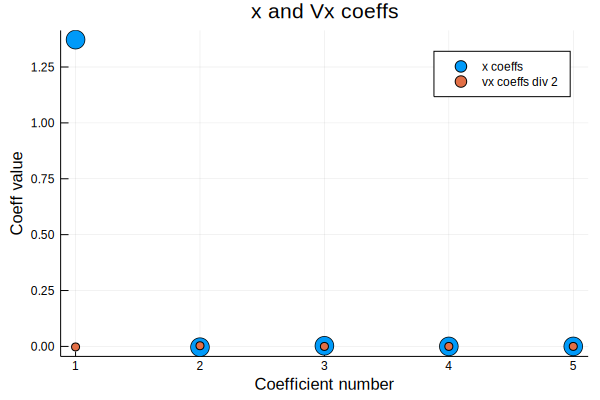

In [18]:
@show true_coeffs_vx

true_coeffs_vx = [-0.00472368, 0.00599834, -9.97296e-5, 5.9838e-7, -1.64946e-9]


5-element Array{Float64,1}:
 -0.004723677148931164
  0.005998335858595632
 -9.972958195714089e-5
  5.98380211926438e-7 
 -1.649458524256055e-9

In [40]:
train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
dt = t_array[2]-t_array[1]

2.2448979591836733

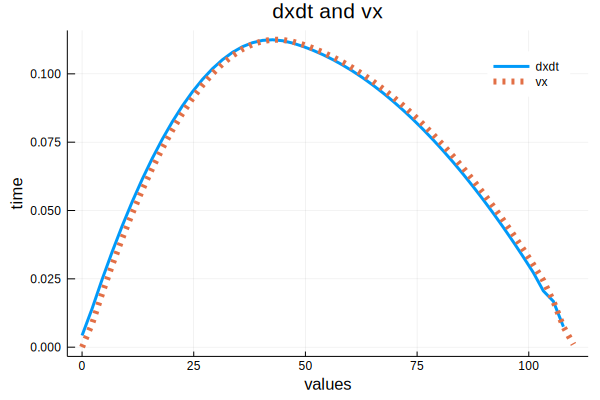

In [71]:
true_x = X_soln_recov[1,:]
true_vx = X_soln_recov[4,:]
dxdt = diff(true_x)/dt
p0 = plot(t_array[1:end-1],dxdt, label = "dxdt",linewidth = 3)
plot!(t_array,true_vx, label = "vx",linewidth = 6,linestyle=:dot)
title!("dxdt and vx")
xlabel!("values")
ylabel!("time")
plot!(legend=:topright,fg_legend = :transparent)


# 

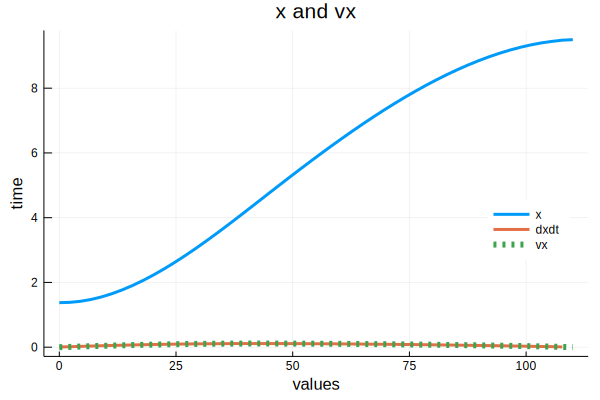

In [51]:
true_x = X_soln_recov[1,:]
true_vx = X_soln_recov[4,:]
dxdt = diff(true_x)/dt
p1 = plot(t_array,true_x,label="x",linewidth = 3)
plot!(t_array[1:end-1],dxdt, label = "dxdt",linewidth = 3)
plot!(t_array,true_vx, label = "vx",linewidth = 6,linestyle=:dot)
title!("x and vx")
xlabel!("values")
ylabel!("time")
plot!(legend=:right,fg_legend = :transparent)


# 

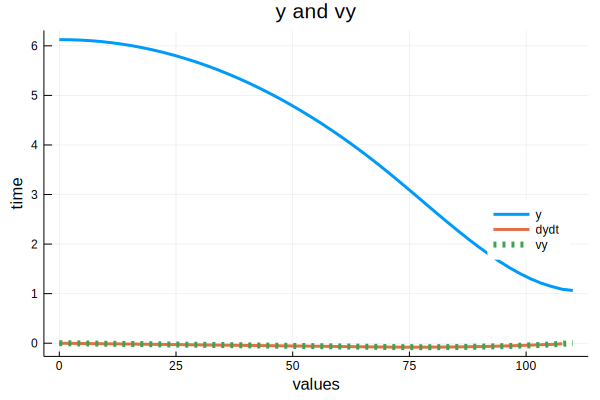

In [52]:
true_y = X_soln_recov[2,:]
true_vy = X_soln_recov[5,:]
dydt = diff(true_y)/dt
p2 = plot(t_array,true_y,label="y",linewidth = 3)
plot!(t_array[1:end-1],dydt, label = "dydt",linewidth = 3)
plot!(t_array,true_vy, label = "vy",linewidth = 6,linestyle=:dot)
title!("y and vy")
xlabel!("values")
ylabel!("time")
plot!(legend=:right,fg_legend = :transparent)

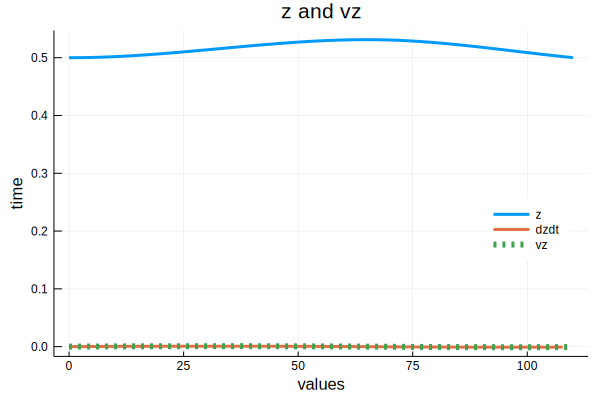

In [53]:
true_z = X_soln_recov[3,:]
true_vz = X_soln_recov[6,:]
dzdt = diff(true_z)/dt
p3 = plot(t_array,true_z,label="z",linewidth = 3)
plot!(t_array[1:end-1],dzdt, label = "dzdt",linewidth = 3)
plot!(t_array,true_vz, label = "vz",linewidth = 6,linestyle=:dot)
title!("z and vz")
xlabel!("values")
ylabel!("time")
plot!(legend=:right,fg_legend = :transparent)

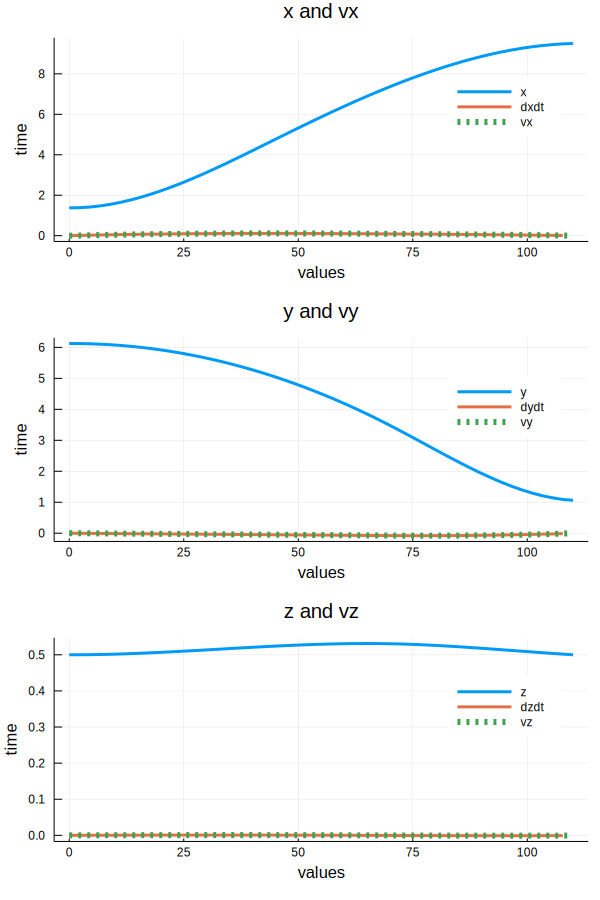

In [55]:
plot(p1,p2,p3,
    layout=(3,1))
plot!(size=(600,900),legend=:true)

## Compare x and vx coeffs
$$x=\sum_{i=0}^4 C_i t^i$$
$$v_x=\sum_{i=1}^4 i \cdot C_i t^{i-1}=\sum_{j=0}^3 (j+1) \cdot C_{j+1} t^{j}$$

$$v_x=\sum_{i=0}^4 A_i t^i$$


row = 2


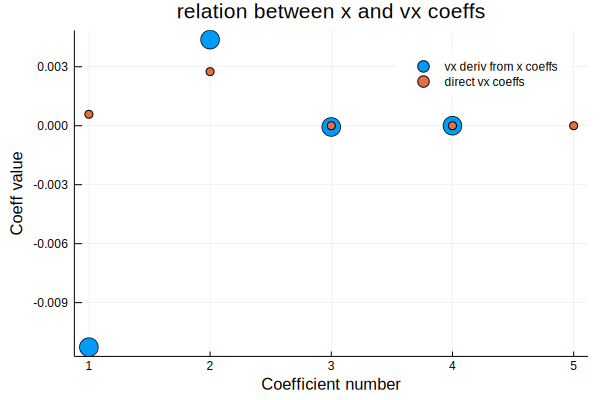

In [136]:
true_vx
row = rand(1:num_rows)
row = 2
@show row
xs = 1:1:5
true_coeffs_x = all_coeffs[row,1:5]
deriv_coeffs_vx = zeros(4)
for i =1:4
    # instead of 0:3, 1:4 so we multiply by i directly not (i+1)
    deriv_coeffs_vx[i] = i * true_coeffs_x[i+1]
end
true_coeffs_vx = all_coeffs[row,16:20]
p1 = scatter(xs[1:end-1],deriv_coeffs_vx,grid=true, label="vx deriv from x coeffs",markersize = 10)
scatter!(xs,true_coeffs_vx,grid=true,label="direct vx coeffs")
title!("relation between x and vx coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best,fg_legend=:transparent)

## How much do the direct and derived coeffs differ?

In [190]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
smape = zeros(num_rows,4)
deriv_coeffs_vx = zeros(num_rows,4)
direct_coeffs_vx = zeros(num_rows,4)
for row in 1:num_rows
    true_coeffs_x = all_coeffs[row,1:5]
    for i =1:4
        # instead of 0:3, 1:4 so we multiply by i directly not (i+1)
        deriv_coeffs_vx[row,i] = i * true_coeffs_x[i+1]
    end
    direct_coeffs_vx[row,:] = all_coeffs[row,16:19]
end
@show minimum(direct_coeffs_vx[:,1])
@show minimum(direct_coeffs_vx[:,2])
@show minimum(direct_coeffs_vx[:,3])
@show minimum(direct_coeffs_vx[:,4])
@show minimum(deriv_coeffs_vx[:,1])
@show minimum(deriv_coeffs_vx[:,2])
@show minimum(deriv_coeffs_vx[:,3])
@show minimum(deriv_coeffs_vx[:,4])

for row in 1:num_rows
    for i = 1:4
        direct = direct_coeffs_vx[row,i]
        deriv = deriv_coeffs_vx[row,i]
        if abs(direct)<=1e-4 && abs(deriv) <= 1e-4
            smape[row,i] = 0.0
        else
            smape[row,i] = abs.(direct - deriv)./(abs.(direct) + abs.(deriv))
        end
    end
    # Can do it in one operation
    # smape[row,:] = abs.(direct_coeffs_vx - deriv_coeffs_vx)./(abs.(direct_coeffs_vx) + abs.(deriv_coeffs_vx))
end

minimum(direct_coeffs_vx[:, 1]) = -0.021309279318047554
minimum(direct_coeffs_vx[:, 2]) = 0.0007277924821211387
minimum(direct_coeffs_vx[:, 3]) = -0.0004170432243093906
minimum(direct_coeffs_vx[:, 4]) = -1.7283175552293127e-6
minimum(deriv_coeffs_vx[:, 1]) = -0.03139291745342917
minimum(deriv_coeffs_vx[:, 2]) = -0.0007280617507296685
minimum(deriv_coeffs_vx[:, 3]) = -0.00021685140457194295
minimum(deriv_coeffs_vx[:, 4]) = -3.0756608198360316e-7


In [191]:
@show mean(smape[:,1])
@show mean(smape[:,2])
@show mean(smape[:,3])
@show mean(smape[:,4])

mean(smape[:, 1]) = 0.3774376210466629
mean(smape[:, 2]) = 0.07809176266798616
mean(smape[:, 3]) = 0.06127659170146518
mean(smape[:, 4]) = 0.0


0.0

size(xs) = (2,)
size(c4_errors) = (2,)


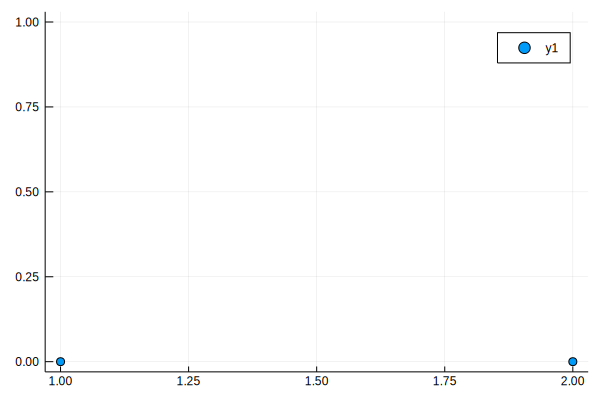

In [192]:
maximum(smape[:,4])
xs = 1:2
@show size(xs)
c4_errors = smape[xs,4]
@show size(c4_errors)
scatter(xs,c4_errors )

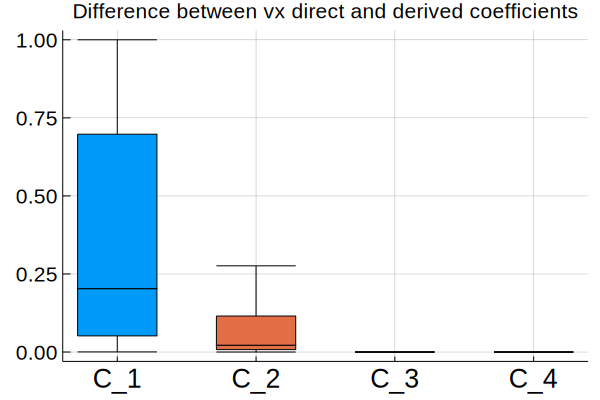

In [193]:
boxplot(["C_1" "C_2" "C_3" "C_4"],smape,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3)
title!("Difference between vx direct and derived coefficients")

## Illustrating numerical errors if we don't discard small numbers

In [187]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
smape = zeros(num_rows,4)
deriv_coeffs_vx = zeros(num_rows,4)
direct_coeffs_vx = zeros(num_rows,4)
for row in 1:num_rows
    true_coeffs_x = all_coeffs[row,1:5]
    for i =1:4
        # instead of 0:3, 1:4 so we multiply by i directly not (i+1)
        deriv_coeffs_vx[row,i] = i * true_coeffs_x[i+1]
    end
    direct_coeffs_vx[row,:] = all_coeffs[row,16:19]
end
@show minimum(direct_coeffs_vx[:,1])
@show minimum(direct_coeffs_vx[:,2])
@show minimum(direct_coeffs_vx[:,3])
@show minimum(direct_coeffs_vx[:,4])
@show minimum(deriv_coeffs_vx[:,1])
@show minimum(deriv_coeffs_vx[:,2])
@show minimum(deriv_coeffs_vx[:,3])
@show minimum(deriv_coeffs_vx[:,4])

for row in 1:num_rows
    for i = 1:4
        direct = abs(direct_coeffs_vx[row,i])
        deriv = abs(deriv_coeffs_vx[row,i])
        # NOT discarding small numbers
#         if direct<=1e-5 && deriv <= 1e-5
#             smape[row,i] = 0.0
#         else
            smape[row,i] = abs.(direct_coeffs_vx[row,i] - deriv_coeffs_vx[row,i])./(abs.(direct_coeffs_vx[row,i]) + abs.(deriv_coeffs_vx[row,i]))
#         end
    end
    # Can do it in one operation
    # smape[row,:] = abs.(direct_coeffs_vx - deriv_coeffs_vx)./(abs.(direct_coeffs_vx) + abs.(deriv_coeffs_vx))
end

minimum(direct_coeffs_vx[:, 1]) = -0.021309279318047554
minimum(direct_coeffs_vx[:, 2]) = 0.0007277924821211387
minimum(direct_coeffs_vx[:, 3]) = -0.0004170432243093906
minimum(direct_coeffs_vx[:, 4]) = -1.7283175552293127e-6
minimum(deriv_coeffs_vx[:, 1]) = -0.03139291745342917
minimum(deriv_coeffs_vx[:, 2]) = -0.0007280617507296685
minimum(deriv_coeffs_vx[:, 3]) = -0.00021685140457194295
minimum(deriv_coeffs_vx[:, 4]) = -3.0756608198360316e-7


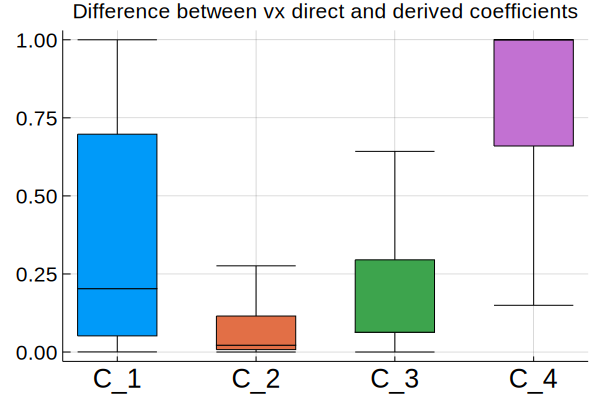

In [188]:
boxplot(["C_1" "C_2" "C_3" "C_4"],smape_no_filt,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3)
title!("Difference between vx direct and derived coefficients")

# Plot the coefficients

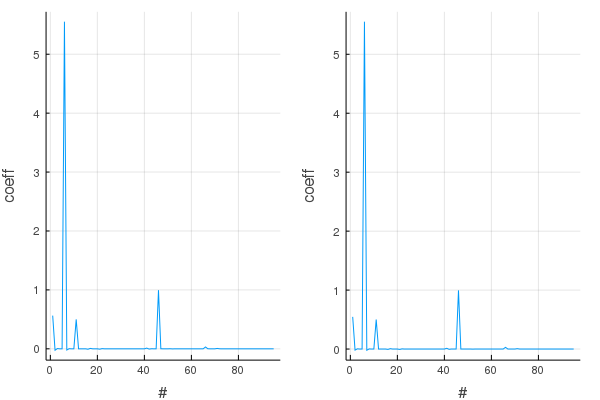

In [7]:
p1 = plotCoeffs(all_coeffs[1,:])
p2 = plotCoeffs(all_coeffs[19,:])
plot(p1,p2)

# Check if the coefficients accurately capture the original data

In [8]:
N = 50
MAX_ITERATIONS_NB = 100

model = AstrobeeSE3()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]

obstacles = []
# obs = [[0.0,0.0,0.0], 6.0]
# push!(obstacles, obs)
model.obstacles = obstacles

poly_obstacles = []
obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
push!(poly_obstacles, obs)
obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
push!(poly_obstacles, obs)
model.poly_obstacles = poly_obstacles

model.tf_guess = 110.
model.convergence_threshold = 0.7

t_array = range(0,stop=tf_guess,length=N)
t_minus_one_array = t_array[1:end-1]

0.0:2.2448979591836733:107.75510204081633

# How do the x trajectories compare?

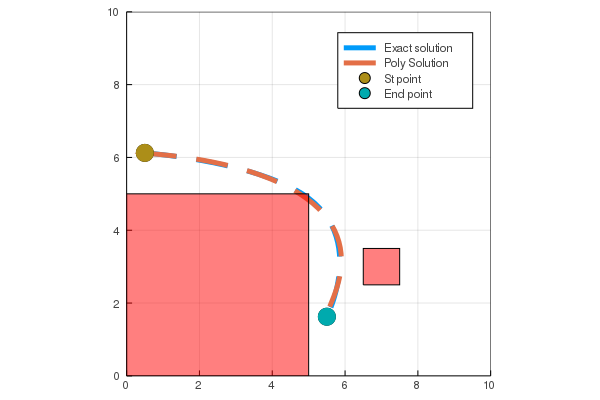

In [9]:
row = 150 # Basic trajectory in straight line

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

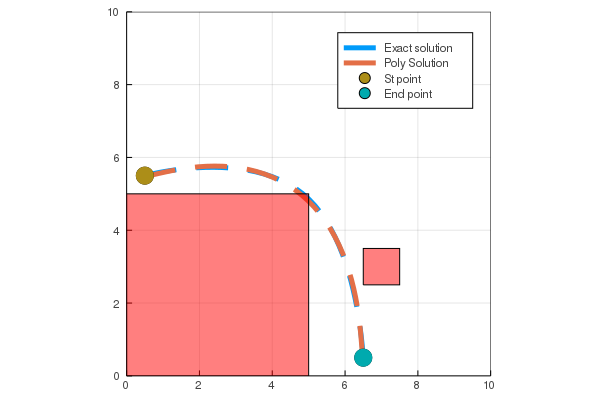

In [10]:
row = 19 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

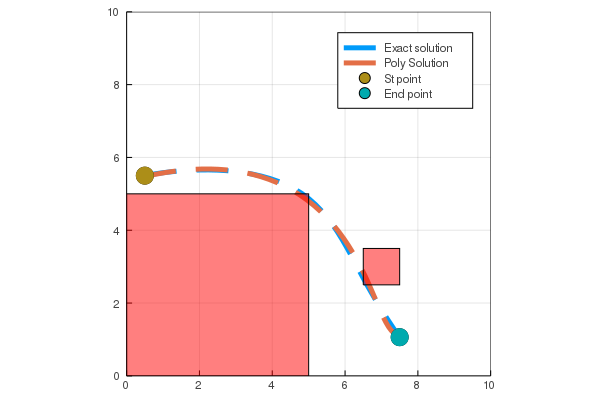

In [11]:
row = 34 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

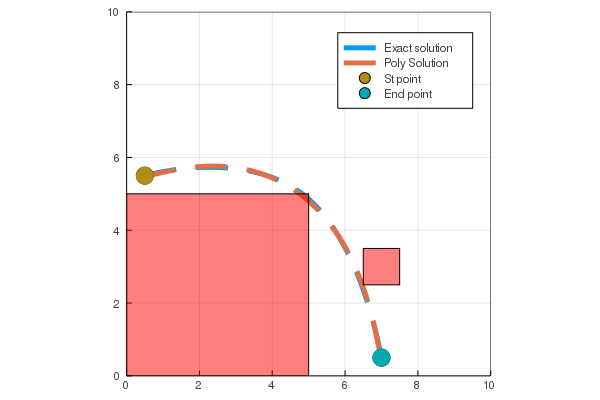

In [12]:
row = 26 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

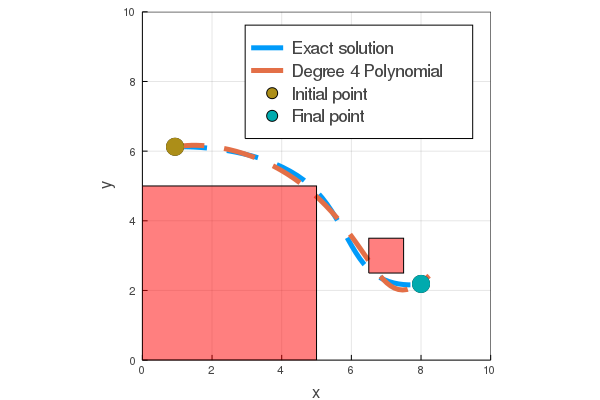

In [30]:
row = 836 # 

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Degree 4 Polynomial"])
xlabel!("x")
ylabel!("y")
plot!(legendfontsize = 12)
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="Initial point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="Final point")

In [31]:
png("polyfitting")

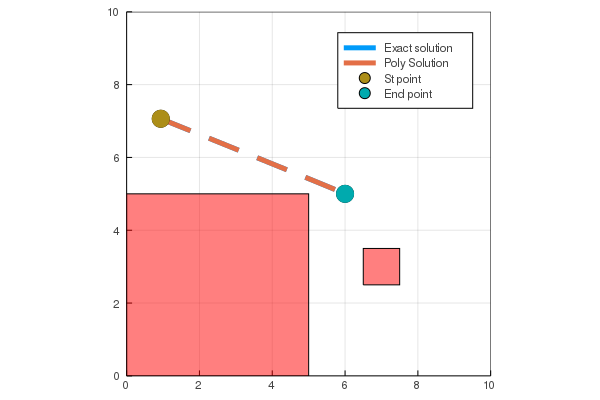

In [14]:
row = 1028 # 

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

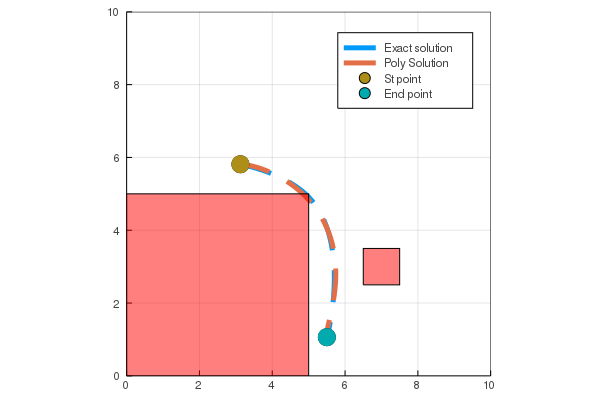

In [15]:
row = 4020 # 

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

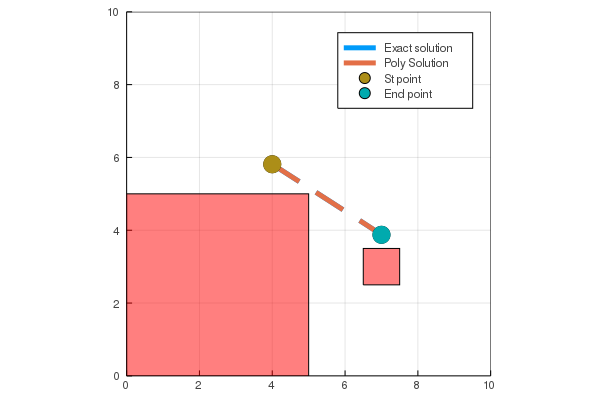

In [16]:
row = 5367 # 

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_x = cf[1:num_coeffs]
cf_y = cf[(num_coeffs+1):(2*num_coeffs)]
x_poly = polyval(Poly(cf_x), t_array)
y_poly = polyval(Poly(cf_y), t_array)
xy_poly = vcat([x_poly', y_poly']...)
plot_env_and_trajs(model, [X_soln_recov, xy_poly],["Exact solution","Poly Solution"])
scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="St point")
scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="End point")

# How does the u solutions compare?

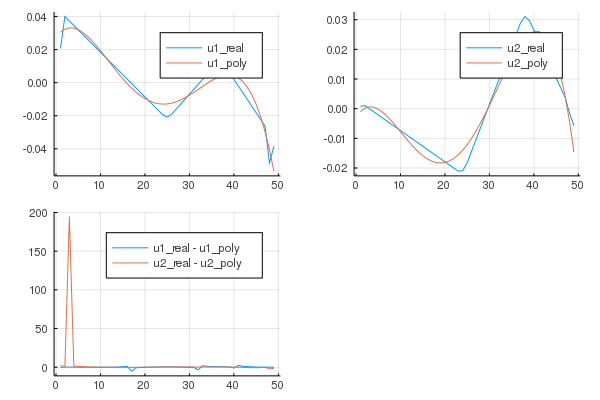

In [17]:
row = 836 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]
cf_u1 = cf[(num_coeffs*x_dim + 1) : (num_coeffs*x_dim) + num_coeffs]
u1_poly = polyval(Poly(cf_u1), t_minus_one_array)
u1_real = U_soln_recov[1,:]
cf_u2 = cf[(num_coeffs*x_dim + num_coeffs +1) : (num_coeffs*x_dim) + 2*num_coeffs]
u2_poly = polyval(Poly(cf_u2), t_minus_one_array)
u2_real = U_soln_recov[2,:]
gr(fmt=:png)
p1 = plot()
plot!(u1_real, label="u1_real")
plot!(u1_poly, label="u1_poly")
p2 = plot()
plot!(u2_real, label="u2_real")
plot!(u2_poly, label="u2_poly")
p3 = plot()
plot!((u1_real-u1_poly)./u1_real, label="u1_real - u1_poly")
plot!((u2_real-u2_poly)./u2_real, label="u2_real - u2_poly")

plot(p1, p2, p3)

# How does the quaternion solutions compare?

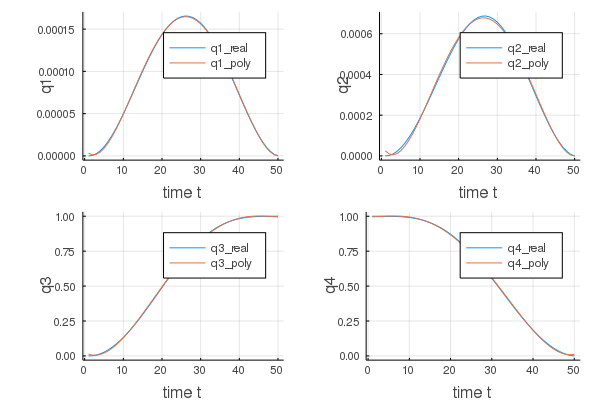

In [18]:
row = 836 # This one is interesting

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

cf = all_coeffs[row,:]


function plotQuaternion(qidx, cf, X_soln_recov, num_coeffs)
    cf_q = cf[(num_coeffs*6 + (qidx-1)*num_coeffs + 1) : (num_coeffs*6 + qidx*num_coeffs)]
    q_poly = polyval(Poly(cf_q), t_array)
    q_real = X_soln_recov[6+qidx,:]
    p1 = plot()
    plot!(q_real, label="q$(qidx)_real")
    plot!(q_poly, label="q$(qidx)_poly", xlabel = "time t", ylabel = "q$(qidx)")
    return p1
end

gr(fmt=:png)
p1 = plotQuaternion(1, cf, X_soln_recov, num_coeffs)
p2 = plotQuaternion(2, cf, X_soln_recov, num_coeffs)
p3 = plotQuaternion(3, cf, X_soln_recov, num_coeffs)
p4 = plotQuaternion(4, cf, X_soln_recov, num_coeffs)
plot(p1,p2, p3, p4)
